# Create dataset of expressions for training similar-expressions model

## Using custom generator (based on NeSymRes and DLSM code)

Creates .txt file with string expressions.

In [3]:
from importlib import reload
import utils
import generator
reload(utils)
reload(generator)
from generator import Generator
from utils import create_generator
import os
import numpy as np
np.random.seed(2)

gen, params = create_generator('./data_settings.json')
# gen.generate_equation(np.random, -1e3, 1e3, simplify=False, check_const_range=True)

# Generate data
N = int(1e4)
expressions = [gen.generate_equation(np.random, -1, 1, simplify=False, check_const_range=True) for _ in range(N)]

In [4]:
expressions[:10]

['sin(0.9307385683059692)',
 'exp(-0.5482306480407715)',
 '(((-0.17322957515716553)*x1)/x1)- x1',
 '(exp(0.6813464164733887+x1))+(-0.38388943672180176)',
 '(0.7175426483154297/0.41971659660339355)/x1',
 'x1+(x1/sin(x1))',
 '(-0.4790302515029907)- x1',
 '0.9457700252532959- (x1*0.052959322929382324)',
 'sin(x1)/0.7833374738693237',
 'exp(x1*(exp(-0.48701179027557373)))']

In [5]:
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'

# Filter out empty strings
expressions = [expr for expr in expressions if expr]

# Save
output_file = os.path.join(datapath, 'expr_240810_1.txt')
with open(output_file, 'w') as f:
    for expr in expressions:
        f.write(f"{expr}\n")

## Parse string to onehot representation

### Whole dataset

In [6]:
import pandas as pd
import h5py
from parsing import parse_dataset
from model.grammar import GCFG

In [7]:
from importlib import reload
import parsing
reload(parsing)
from parsing import parse_dataset

# Load data
datapath = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data/expr_240810_1.txt'
with open(datapath, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]

# Parse dataset
syntax, invalid, consts = parse_dataset(eqs)

# Save parsed dataset
with h5py.File(f'{datapath[:-4]}-parsed.h5', 'w') as f:
    f.create_dataset('data', data=syntax)
    f.create_dataset('invalid_indices', data=invalid)

AssertionError: 

## Create function value dataset

In [369]:
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [370]:
from model.util import load_raw_parsed_data

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
name = 'expr_240809_1'
eqs, syntax = load_raw_parsed_data(datapath, name)

In [408]:
import sympy as sp
from sympy import oo, zoo, nan

MAX_ABS_VAL = 1e5

x = np.linspace(-10, 10, 100)
y = np.empty((len(eqs), len(x)))

import multiprocess as mp

def process_equation(args):
    eq, all_x = args

    expr = sp.sympify(eq)
    if expr.has(oo, -oo, zoo, nan):
        return np.full(len(all_x), np.nan, dtype=np.float32)

    try:
        res = np.zeros(len(all_x), dtype=np.float32)
        for i, x in enumerate(all_x):
            value = expr.evalf(subs={sp.Symbol('x1'): x})
            if abs(value) < np.finfo(np.float32).max:
                res[i] = value
            else:
                return np.full(len(all_x), np.nan, dtype=np.float32)
        return res
    except TypeError:
        return np.full(len(all_x), np.nan, dtype=np.float32)


with mp.Pool() as pool:
    results = pool.map(process_equation, [(eq, x) for eq in eqs])

y = np.array(results).astype(np.float32)

invalid = np.any(np.isinf(y) | (np.abs(y) > MAX_ABS_VAL) | np.isnan(y), axis=1)
invalid.sum() / len(invalid)

values = y[~invalid]

In [411]:
import h5py

# Save parsed dataset
with h5py.File(f'{datapath}/{name}-values.h5', 'w') as f:
    f.create_dataset('data', data=values)
    f.create_dataset('invalid_mask', data=invalid)

## Analyse syntax data

In [412]:
from util import load_raw_parsed_value_data
import pandas as pd
import numpy as np

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, syntax, values = load_raw_parsed_value_data(datapath, 'expr_240809_1')

In [413]:
prod_idx = syntax[:, :, :-1].argmax(axis=-1)

unique_rows, counts = np.unique(prod_idx, axis=0, return_counts=True)
print(f"Number of unique rows: {len(unique_rows)}")
res = sorted(zip(unique_rows, counts), key=lambda x: x[1], reverse=True)

for row, count in res[:10]:
    print(f"Row: {row}, Count: {count}")

Number of unique rows: 5154
Row: [ 4  6  4  7  4  7  4  8 10 10 10 10 10 10 10], Count: 42
Row: [ 4  7  4  7  4  6  4  8 10 10 10 10 10 10 10], Count: 42
Row: [ 4  6  4  7  4  6  4  8 10 10 10 10 10 10 10], Count: 35
Row: [ 4  7  4  7  4  6  4  9 10 10 10 10 10 10 10], Count: 35
Row: [ 4  6  4  7  4  6  4  9 10 10 10 10 10 10 10], Count: 33
Row: [ 4  6  4  7  4  7  4  9 10 10 10 10 10 10 10], Count: 33
Row: [ 4  6  4  6  4  7  4  9 10 10 10 10 10 10 10], Count: 32
Row: [ 4  7  4  6  4  6  4  9 10 10 10 10 10 10 10], Count: 30
Row: [ 4  6  4  6  4  7  4  8 10 10 10 10 10 10 10], Count: 29
Row: [ 4  7  4  7  4  7  4  9 10 10 10 10 10 10 10], Count: 28


In [414]:
from util import logits_to_prods, prods_to_eq
from grammar import GCFG
import torch


# Print 5 expressions with the same production
n = 54
for i in np.where(np.all(prod_idx == res[n][0], axis=1))[0][:5]:
    prods = logits_to_prods(torch.tensor(syntax[i].squeeze()), GCFG)
    eq = prods_to_eq(prods)
    print(eq)
    

exp( x1 - sin( x1 ) )
exp( x1 - sin( x1 ) )
exp( x1 - sin( x1 ) )
exp( x1 - sin( x1 ) )
exp( x1 - sin( x1 ) )


In [415]:
# Print expressions from each unique production

for n in range(20):
    i = np.where(np.all(prod_idx == res[n][0], axis=1))[0][0]
    prods = logits_to_prods(torch.tensor(syntax[i].squeeze()), GCFG, insert_const=False)
    eq = prods_to_eq(prods)
    print(n, '\t', eq)

0 	 sin( exp( exp( x1 ) ) )
1 	 exp( exp( sin( x1 ) ) )
2 	 sin( exp( sin( x1 ) ) )
3 	 exp( exp( sin( [CONST] ) ) )
4 	 sin( exp( sin( [CONST] ) ) )
5 	 sin( exp( exp( [CONST] ) ) )
6 	 sin( sin( exp( [CONST] ) ) )
7 	 exp( sin( sin( [CONST] ) ) )
8 	 sin( sin( exp( x1 ) ) )
9 	 exp( exp( exp( [CONST] ) ) )
10 	 sin( sin( sin( [CONST] ) ) )
11 	 exp( sin( exp( x1 ) ) )
12 	 sin( sin( sin( x1 ) ) )
13 	 exp( sin( sin( x1 ) ) )
14 	 exp( sin( exp( [CONST] ) ) )
15 	 x1 / exp( sin( x1 ) )
16 	 sin( sin( x1 ) ) + x1
17 	 x1 + exp( sin( x1 ) )
18 	 x1 * sin( sin( x1 ) )
19 	 x1 * sin( exp( x1 ) )


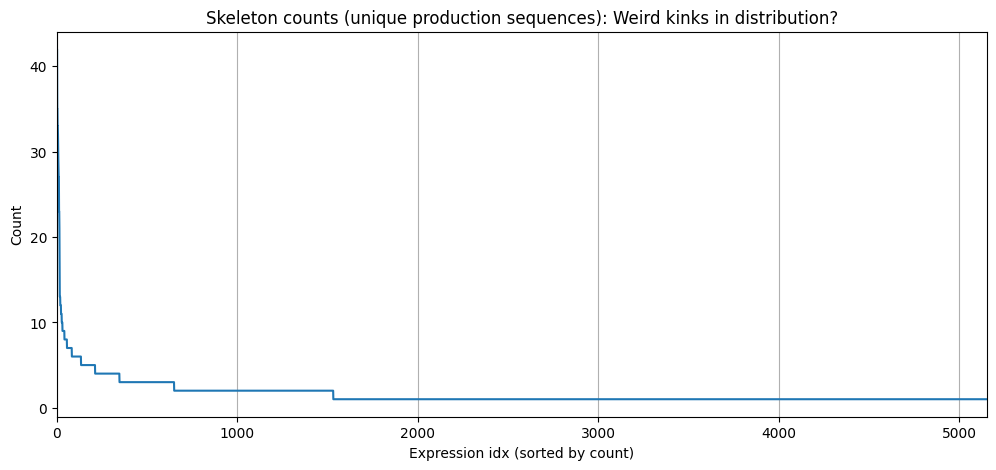

In [424]:
from matplotlib import pyplot as plt

counts_sorted = np.sort(counts)[::-1]

fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(counts_sorted)
# ax2 = plt.twinx()
# ax2.plot(pd.Series(counts_sorted).diff().rolling(window=2).mean(), color='orange')
# ax2.set_ylabel('Count diff')

ax.set_xlabel('Expression idx (sorted by count)')
ax.set_ylabel('Count')
plt.xlim(0, len(counts_sorted))
# plt.xlim(1000, len(res))
# ax.set_ylim(0, 50)
ax.grid(axis='x')
plt.title('Skeleton counts (unique production sequences): Weird kinks in distribution?')
plt.show()

In [420]:
prod_counts = pd.Series(syntax[:, :, :-1].argmax(axis=-1).flatten()).value_counts()
labels = {i: str(prod) for i, prod in enumerate(GCFG.productions())}
prod_counts.index = prod_counts.index.map(labels)
prod_counts

Nothing -> None      34998
S -> T               31494
T -> '(' S ')'       12524
T -> 'x1'            12087
T -> '[CONST]'       11833
T -> 'sin(' S ')'     5643
T -> 'exp(' S ')'     4749
S -> S '-' T          3923
S -> S '+' T          3854
S -> S '/' T          3827
S -> S '*' T          3738
Name: count, dtype: int64

## Analyse function value data

Use this to decide on value transformation

In [425]:
from util import load_raw_parsed_value_data
import pandas as pd
import numpy as np

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, syntax, values = load_raw_parsed_value_data(datapath, 'expr_240809_1')
x = np.linspace(-10, 10, 100)

In [426]:
a = pd.Series(values.flatten())
a.describe()

count    857800.000000
mean        110.063080
std        2289.642334
min      -98669.328125
25%          -0.599181
50%           0.287467
75%           1.641766
max       98232.484375
dtype: float64

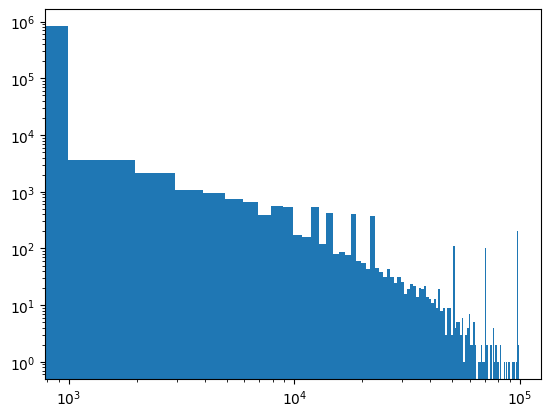

In [427]:
from matplotlib import pyplot as plt

plt.hist(a.abs(), bins=100)
plt.yscale('log')
plt.xscale('log')

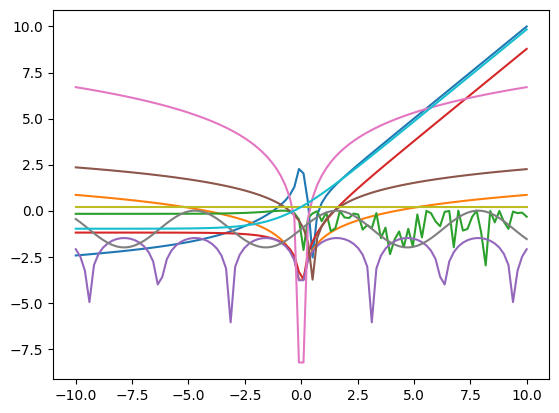

In [428]:
# Example function
plt.plot(x, np.log(np.abs(values[:10, :].T)))

In [96]:
import util
from importlib import reload
reload(util)
from util import load_data
import torch

def value_transform(x):
    eps = 1e-10
    return torch.log(torch.abs(x) + eps)/10  # Example transformation


datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
train_loader, test_loader = load_data(datapath, 'expr_240807_5', test_split=0.1, batch_size=int(1e5), value_transform=value_transform)

_, _, _, y_values = next(iter(train_loader))
x = np.linspace(-10, 10, 100)

In [97]:
pd.Series(y_values.flatten()).describe()

count    7.570800e+06
mean     4.076056e-02
std      2.773862e-01
min     -2.302585e+00
25%     -7.867037e-02
50%      2.616519e-02
75%      1.874362e-01
max      1.150888e+00
dtype: float64

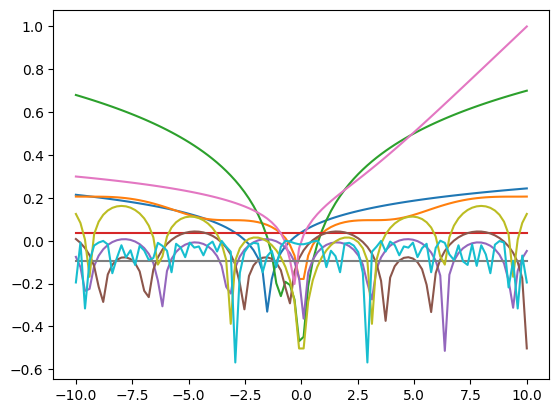

In [103]:
from matplotlib import pyplot as plt

plt.plot(x, y_values[:10, :].T)
plt.show()

## Analyse priors: syntax, constant function value

In [429]:
from util import load_raw_parsed_value_data
import pandas as pd
import numpy as np
from grammar import GCFG

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, syntax, values = load_raw_parsed_value_data(datapath, 'expr_240809_1')

def value_transform(x):
    eps = 1e-10
    return torch.log(torch.abs(x) + eps)/10  # Example transformation


# Calculate production counts
prod_counts = pd.Series(syntax[:, :, :-1].argmax(axis=-1).flatten()).value_counts()
labels = {i: str(prod) for i, prod in enumerate(GCFG.productions())}
prod_counts.index = prod_counts.index.map(labels)
print(prod_counts)

# Calculate cross entropy prior for syntax
p = prod_counts / prod_counts.sum()
cross_entropy_prior = -np.sum(p * np.log(p))
print(f'\n{cross_entropy_prior = }')

# Calculate MSE prior for constants
consts = syntax[:, :, -1].flatten()
mse_prior_consts = consts.var()
print(f'{mse_prior_consts = }')

# Calculate MSE prior for values
values_transformed = value_transform(torch.tensor(values)).flatten().detach().numpy()
mse_prior_values = values_transformed.var()
print(f'{mse_prior_values = }')

Nothing -> None      34998
S -> T               31494
T -> '(' S ')'       12524
T -> 'x1'            12087
T -> '[CONST]'       11833
T -> 'sin(' S ')'     5643
T -> 'exp(' S ')'     4749
S -> S '-' T          3923
S -> S '+' T          3854
S -> S '/' T          3827
S -> S '*' T          3738
Name: count, dtype: int64

cross_entropy_prior = 2.0447648982274034
mse_prior_consts = 0.0307035554081931
mse_prior_values = 0.14959595
